In [1]:
# imports 
import pandas as pd 
import pickle
import glob
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from collections import Counter

In [21]:
# read in the set of phrogs that we want to use for threshold selection
# Get the phrogs that pass the length and plddt filters 
with open('../files/phrogs_pass_plddt_length_threshold_alphafold_trained.txt', 'r') as file:
    phrogs_pass_alphafold_seen =  [line.strip() for line in file]
print(len(phrogs_pass_alphafold_seen))

# read in the ones that haven't been seen by alphafold
with open('../files/phrogs_pass_plddt_length_threshold_validation_alphafold_unseen.txt', 'r') as file:
    phrogs_pass_alphafold_unseen =  [line.strip() for line in file]
len(phrogs_pass_alphafold_unseen)

558


39

### Color scheme to use 


In [3]:
colors = ['#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#ffed6f', '#ccebc5', '#8dd3c7',   '#bebada', '#bc80bd','#fccde5', 
          '#d9d9d9']

## Read in the oligomeric states of pdb hits 

In [22]:
# read in the oligomeric state of these as deposited in the pdb 
alphafold_known_state = pickle.load(open('../files/../files/phrogs_pass_plddt_length_threshold_oligomeric_state.pkl', 'rb'))

In [23]:
len(alphafold_known_state) # covers those in the seen and unseen states 

597

Curate the oligomeric state of pdb states

In [6]:
# apply criteria to filter this dictionary 
keys = list(alphafold_known_state.keys())

phrogs_pass_alphafold_seen_state = dict()
labelled_monomers = [] # flag the monomers as these require manual curation 

for k in keys: 
    
    # see if phrog has been curated as a Monomer manually
    # nothing is happening here at the moment - not currently incorporating the manual check 

    if list(alphafold_known_state.get(k).keys()) == ['Monomer']: # this here is if it is only ever listed as a monomer 
        phrogs_pass_alphafold_seen_state[k] = 'Monomer'
        labelled_monomers.append(k)
    
    # otherwise look at pdb hits 
    else: 
        states = alphafold_known_state.get(k)

        # correct any keys in states that mention more than one state
        double_keys = [s for s in list(states.keys()) if '\'' in s] 
        if len(double_keys) > 0: 

            for j in double_keys: 
                split = re.split(', ', j) 
                for s in split: 
                    if s in list(states.keys()):
                        states[s.replace('\'', '')] += 1
                    else: 
                        states[s.replace('\'', '')] = 1

                del states[j]

    
        # Delete monomers from the states dictionary - if there is a high state this is more likely 
        if 'Monomer' in list(states.keys()):
            del states['Monomer']
            
        # TODO return here to see if there are any missing from the manual curation 
        
        # apply criteria that there shouldn't be more than 3 possible states 
        if len(states) > 3: 
            phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
        
        # check that the 'winning' state represents at least 70% of the hits 
        else: 
            
            if len(states) > 0: 
                
                # generate a dataframe with number of hits to each state
                hits_df = pd.DataFrame.from_dict(states, orient='index').sort_values(0, ascending=False)
                
                # compute the 'dominance' of this top state 
                dominance = hits_df.iloc[0]/hits_df[0].sum()
                
                if dominance[0] >= 0.65: 
                    phrogs_pass_alphafold_seen_state[k] = hits_df.index[0]
                else: 
                    phrogs_pass_alphafold_seen_state[k] = 'ambiguous'

                #print(states)

In [7]:
Counter(phrogs_pass_alphafold_seen_state.values())

Counter({'Monomer': 168,
         'Homo 3-mer': 25,
         'Homo 2-mer': 195,
         'Homo 12-mer': 3,
         'ambiguous': 122,
         'Homo 6-mer': 19,
         'Homo 4-mer': 34,
         'Homo 5-mer': 8,
         'Homo 18-mer': 2,
         'Homo 16-mer': 1,
         'Homo 24-mer': 2,
         'Homo 8-mer': 6,
         'Homo 7-mer': 1,
         'Homo 9-mer': 3,
         'Homo 420-mer': 3,
         'Homo 30-mer': 1,
         'Homo 35-mer': 1,
         'Homo 10-mer': 2,
         'Homo 20-mer': 1})

In [8]:
# read in the metrics generated for the 25,000+ phrogs
part_1 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_001.phlegm/metrics_pickle/*.pkl') 
part_2 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_002.phlegm/metrics_pickle/*.pkl')
part_3 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_003.phlegm/metrics_pickle/*.pkl')
part_4 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_004.phlegm/metrics_pickle/*.pkl')
part_5 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_005.phlegm/metrics_pickle/*.pkl')
part_6 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_006.phlegm/metrics_pickle/*.pkl') 
part_7 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_007.phlegm/metrics_pickle/*.pkl')
part_8 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_008.phlegm/metrics_pickle/*.pkl')
all_parts =  part_1 + part_2 + part_3 + part_4 + part_5 + part_6 + part_7 + part_8

In [9]:
all_phrogs_pickle_complete = [re.split('/', p)[-1][:-4] for p in all_parts]

# filter these to only inlucde the ones that pass the plddt cutoff 
all_phrogs_alphafold_seen_complete = list(set(all_phrogs_pickle_complete).intersection(set(phrogs_pass_alphafold_seen))) 

#all_phrogs_pickle_complete_seen = np.array(all_phrogs_alphafold_seen_complete)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_alphafold_seen_complete ]]
#all_phrogs_pickle_complete_seen_path = np.array(all_parts)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_pickle_complete]]

# make a dictionary that map|s the phrog to its metrics path 
pickle_paths = dict(zip(all_phrogs_pickle_complete, all_parts))

## Compare the monomers and dimers

In [12]:
seen_monomers = [i for i in list(phrogs_pass_alphafold_seen_state.keys())  if phrogs_pass_alphafold_seen_state.get(i) == 'Monomer']
#seen_monomers = [m for m in seen_monomers if m in confirmed_monomer_phrogs]
seen_dimers =  [i for i in list(phrogs_pass_alphafold_seen_state.keys())  if phrogs_pass_alphafold_seen_state.get(i) == 'Homo 2-mer']

print(len(seen_dimers))
print(len(seen_monomers))

# curate metrics to show as a distribution 
# show the best one in the main text of the paper and others in the supp info 
monomer_mean_iptm = []
monomer_max_iptm = []
monomer_mean_ptm = []
monomer_max_ptm = []
monomer_mean_ncontacts = []
monomer_max_ncontacts = []
monomer_mean_pdockq2 = []
monomer_max_pdockq2 = [] 
monomer_mean_plddt = [] 
monomer_max_plddt = [] 
monomer_mean_iplddt = [] 
monomer_max_iplddt = [] 
monomer_mean_pae = []
monomer_max_pae = [] 
monomer_mean_avgif_pae = [] 
monomer_max_avgif_pae = []
dimer_mean_iptm = [] 
dimer_max_iptm = [] 
dimer_mean_ptm = []
dimer_max_ptm = []
dimer_mean_ncontacts = []
dimer_max_ncontacts = []
dimer_mean_pdockq2 = [] 
dimer_max_pdockq2 = [] 
dimer_mean_plddt = [] 
dimer_max_plddt = [] 
dimer_mean_iplddt = [] 
dimer_max_iplddt = [] 
dimer_mean_pae = [] 
dimer_max_pae = [] 
dimer_mean_avgif_pae = [] 
dimer_max_avgif_pae = [] 


for m in seen_monomers: 
    metrics = pickle.load(open(pickle_paths.get(m), 'rb'))
    
    if '2_subunits' in list(metrics.keys()):
    
        # add the iptm score
        iptm =  [metrics.get('2_subunits').get('rep_' + str(i)).get('iptm') for i in range(1,6)] 
        mean_iptm = np.mean(iptm)
        monomer_mean_iptm.append(mean_iptm) 
        max_iptm = np.max(iptm)
        monomer_max_iptm.append(max_iptm) 
        
        # add the ptm score
        ptm =  [metrics.get('2_subunits').get('rep_' + str(i)).get('ptm') for i in range(1,6)] 
        mean_ptm = np.mean(ptm)
        monomer_mean_ptm.append(mean_ptm) 
        max_ptm = np.max(ptm)
        monomer_max_ptm.append(max_ptm)
        
        # add the number of contacts at 4A
        ncontacts =  [metrics.get('2_subunits').get('rep_' + str(i)).get('n_contacts_4A')[0] for i in range(1,6)] 
        mean_ncontacts = np.mean(ncontacts)
        monomer_mean_ncontacts.append(mean_ncontacts) 
        max_ncontacts = np.max(ncontacts)
        monomer_max_ncontacts.append(max_ncontacts) 

        # add the pdock2 score 
        pdockq2 = [metrics.get('2_subunits').get('rep_' + str(i)).get('pdockq2') for i in range(1,6)]
        mean_pdockq2 = np.mean(pdockq2)
        monomer_mean_pdockq2.append(mean_pdockq2) 
        max_pdockq2 = np.max(pdockq2)
        monomer_max_pdockq2.append(max_pdockq2) 

        # add the plddt score 
        plddt =  [metrics.get('2_subunits').get('rep_' + str(i)).get('mean_plddt') for i in range(1,6)]
        mean_plddt = np.mean(plddt)
        monomer_mean_plddt.append(mean_plddt) 
        max_plddt = np.max(plddt)
        monomer_max_plddt.append(max_plddt) 
        
        # add the interface plddt score 
        iplddt =  [metrics.get('2_subunits').get('rep_' + str(i)).get('plddt_lst') for i in range(1,6)]
        mean_iplddt = np.mean(iplddt)
        monomer_mean_iplddt.append(mean_iplddt) 
        max_iplddt = np.max(iplddt)
        monomer_max_iplddt.append(max_iplddt) 
        
        # add the max pae score 
        pae =  [metrics.get('2_subunits').get('rep_' + str(i)).get('max_pae') for i in range(1,6)]
        mean_pae = np.mean(pae)
        monomer_mean_pae.append(mean_pae) 
        max_pae = np.max(pae)
        monomer_max_pae.append(max_pae) 
        

        # add the avgif pae 
        avgif_pae = [metrics.get('2_subunits').get('rep_' + str(i)).get('avgif_pae') for i in range(1,6)]
        mean_avgif_pae = np.mean(avgif_pae)
        monomer_mean_avgif_pae.append(mean_avgif_pae) 
        max_avgif_pae = np.max(avgif_pae)
        monomer_max_avgif_pae.append(max_avgif_pae) 
    
for d in seen_dimers: 
    metrics = pickle.load(open(pickle_paths.get(d), 'rb'))
    
    if '2_subunits' in list(metrics.keys()):
    
        # add the iptm score
        iptm =  [metrics.get('2_subunits').get('rep_' + str(i)).get('iptm') for i in range(1,6)] 
        mean_iptm = np.mean(iptm)
        dimer_mean_iptm.append(mean_iptm) 
        max_iptm = np.max(iptm)
        dimer_max_iptm.append(max_iptm) 
        
        # add the ptm score
        ptm =  [metrics.get('2_subunits').get('rep_' + str(i)).get('ptm') for i in range(1,6)] 
        mean_ptm = np.mean(ptm)
        dimer_mean_ptm.append(mean_ptm) 
        max_ptm = np.max(ptm)
        dimer_max_ptm.append(max_ptm)
        
        # add the number of contacts at 4A
        ncontacts =  [metrics.get('2_subunits').get('rep_' + str(i)).get('n_contacts_4A')[0] for i in range(1,6)] 
        mean_ncontacts = np.mean(ncontacts)
        dimer_mean_ncontacts.append(mean_ncontacts) 
        max_ncontacts = np.max(ncontacts)
        dimer_max_ncontacts.append(max_ncontacts) 

        # add the pdockq2 score
        pdockq2 = [metrics.get('2_subunits').get('rep_' + str(i)).get('pdockq2') for i in range(1,6)]
        mean_pdockq2 = np.mean(pdockq2)
        dimer_mean_pdockq2.append(mean_pdockq2) 
        max_pdockq2 = np.max(pdockq2)
        dimer_max_pdockq2.append(max_pdockq2) 
        
        # add the plddt score
        plddt =  [metrics.get('2_subunits').get('rep_' + str(i)).get('mean_plddt') for i in range(1,6)]
        mean_plddt = np.mean(plddt)
        dimer_mean_plddt.append(mean_plddt) 
        max_plddt = np.max(plddt)
        dimer_max_plddt.append(max_plddt) 
        
        # add the interface plddt score 
        iplddt =  [metrics.get('2_subunits').get('rep_' + str(i)).get('plddt_lst') for i in range(1,6)]
        mean_iplddt = np.mean(iplddt)
        dimer_mean_iplddt.append(mean_iplddt) 
        max_iplddt = np.max(iplddt)
        dimer_max_iplddt.append(max_iplddt) 
        
        # add the max pae score 
        pae =  [metrics.get('2_subunits').get('rep_' + str(i)).get('max_pae') for i in range(1,6)]
        mean_pae = np.mean(pae)
        dimer_mean_pae.append(mean_pae) 
        max_pae = np.max(pae)
        dimer_max_pae.append(max_pae) 

        # add the avgif_pae score 
        avgif_pae = [metrics.get('2_subunits').get('rep_' + str(i)).get('avgif_pae') for i in range(1,6)]
        mean_avgif_pae = np.mean(avgif_pae)
        dimer_mean_avgif_pae.append(mean_avgif_pae) 
        max_avgif_pae = np.max(avgif_pae)
        dimer_max_avgif_pae.append(max_avgif_pae) 
    

195
168


## Shouldn't be including monomers below the cutoff here - go back and check this 

Plot the mean of the metrics

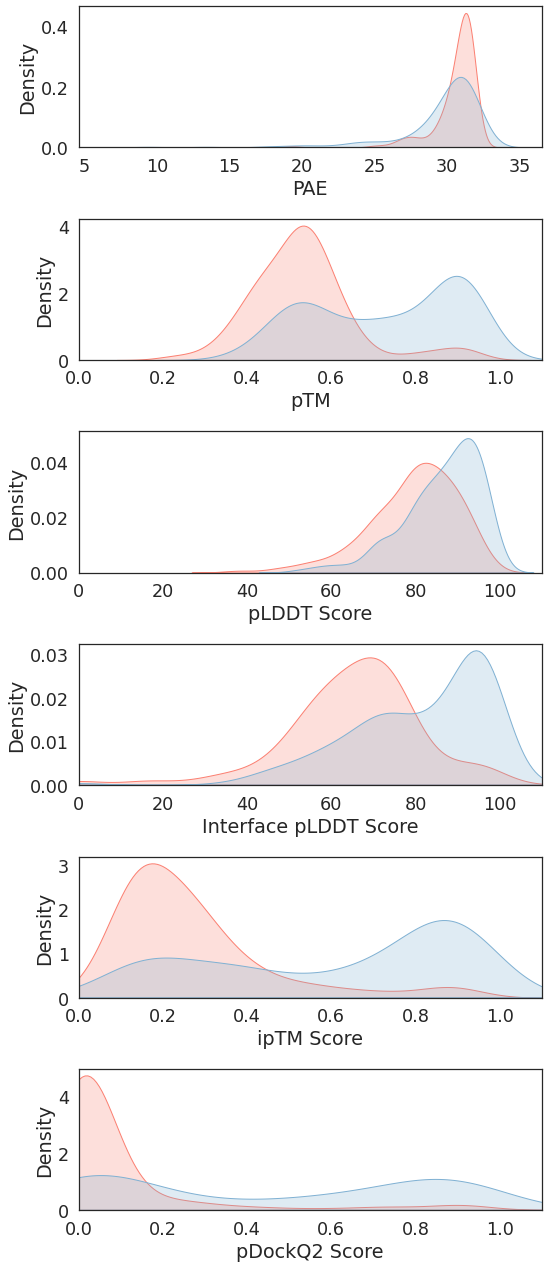

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', font_scale=1.6)
fig, axes = plt.subplots(6, 1, figsize=(8, 18))  # 8 rows, 1 column
colors = ['#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#ffed6f', '#ccebc5', '#8dd3c7', '#bebada', '#bc80bd', '#fccde5', '#d9d9d9']

# --- 1. PAE ---
sns.kdeplot(monomer_mean_pae, label='Monomer', fill=True, color=colors[0], ax=axes[0])
sns.kdeplot(dimer_mean_pae, label='Dimer', fill=True, color=colors[1], ax=axes[0])
axes[0].set_xlabel('PAE')
axes[0].set_ylabel('Density')
axes[0].legend().remove()

# --- 2. pTM ---
sns.kdeplot(monomer_mean_ptm, label='Monomer', fill=True, color=colors[0], ax=axes[1])
sns.kdeplot(dimer_mean_ptm, label='Dimer', fill=True, color=colors[1], ax=axes[1])
axes[1].set_xlim(0, 1.1)
axes[1].set_xlabel('pTM')
axes[1].set_ylabel('Density')
axes[1].legend().remove()

# --- 3. pLDDT ---
sns.kdeplot(monomer_mean_plddt, label='Monomer', fill=True, color=colors[0], ax=axes[2])
sns.kdeplot(dimer_mean_plddt, label='Dimer', fill=True, color=colors[1], ax=axes[2])
axes[2].set_xlim(0, 110)
axes[2].set_xlabel('pLDDT Score')
axes[2].set_ylabel('Density')
axes[2].legend().remove()

# --- 4. Interface pLDDT ---
sns.kdeplot(monomer_mean_iplddt, label='Monomer', fill=True, color=colors[0], ax=axes[3])
sns.kdeplot(dimer_mean_iplddt, label='Dimer', fill=True, color=colors[1], ax=axes[3])
axes[3].set_xlim(0, 110)
axes[3].set_xlabel('Interface pLDDT Score')
axes[3].set_ylabel('Density')
axes[3].legend().remove()

# --- 5. ipTM ---
sns.kdeplot(monomer_mean_iptm, label='Monomer', fill=True, color=colors[0], ax=axes[4])
sns.kdeplot(dimer_mean_iptm, label='Dimer', fill=True, color=colors[1], ax=axes[4])
axes[4].set_xlim(0, 1.1)
axes[4].set_xlabel('ipTM Score')
axes[4].set_ylabel('Density')
axes[4].legend().remove()

# --- 6. pDockQ2 ---
sns.kdeplot(monomer_mean_pdockq2, label='Monomer', fill=True, color=colors[0], ax=axes[5])
sns.kdeplot(dimer_mean_pdockq2, label='Dimer', fill=True, color=colors[1], ax=axes[5])
axes[5].set_xlim(0, 1.1)
axes[5].set_xlabel('pDockQ2 Score')
axes[5].set_ylabel('Density')
axes[5].legend().remove()



# Layout adjustments
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_mean_metric_dist.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_3186503/719385487.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3186503/719385487.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3186503/719385487.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3186503/719385487.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3186503/719385487.py:26: FutureWa

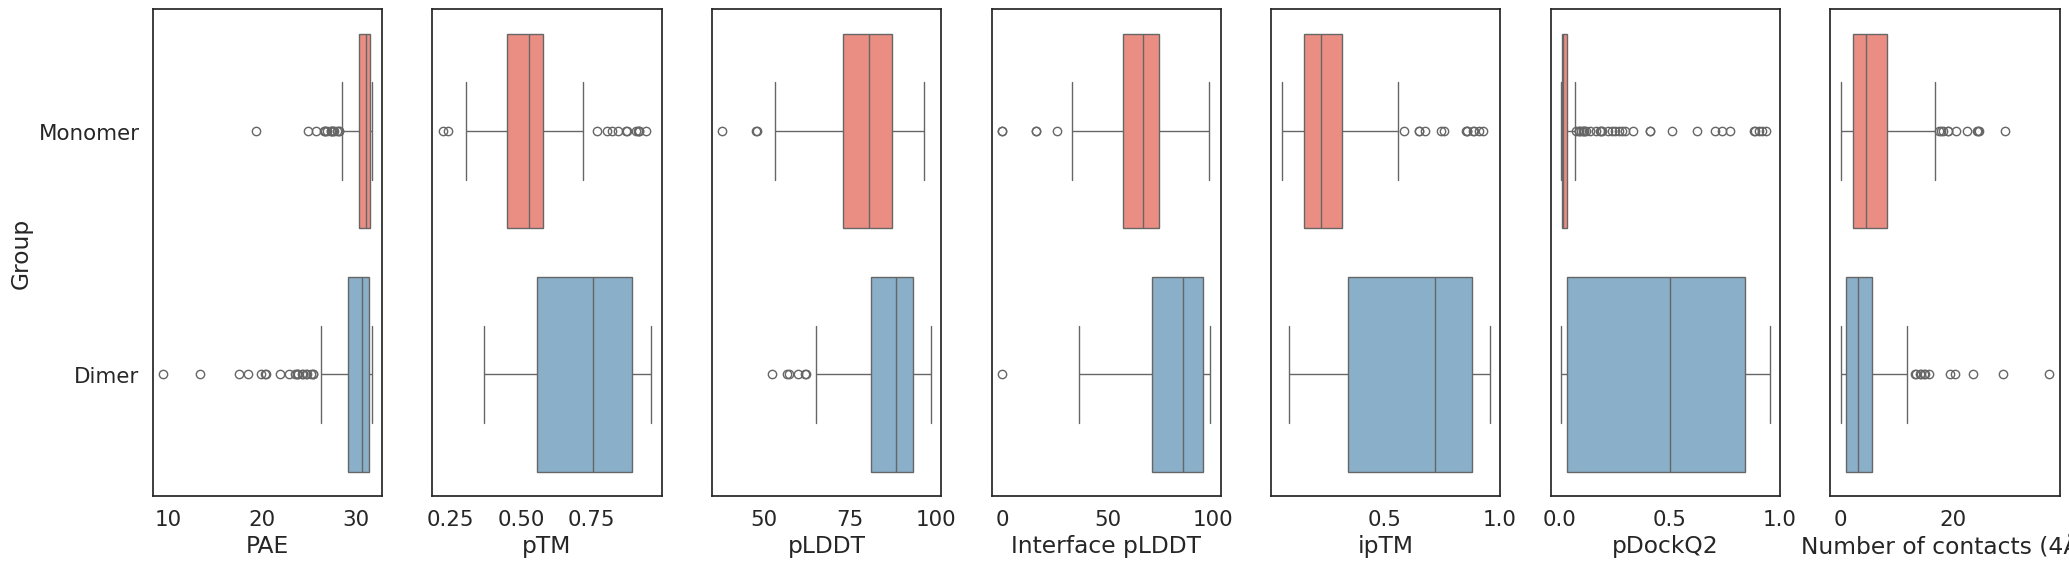

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all data into a single DataFrame for easy plotting with seaborn
data = pd.DataFrame({
    'PAE': list(monomer_mean_pae) + list(dimer_mean_pae),
    'pTM': list(monomer_mean_ptm) + list(dimer_mean_ptm),
    'pLDDT': list(monomer_mean_plddt) + list(dimer_mean_plddt),
    'Interface pLDDT': list(monomer_mean_iplddt) + list(dimer_mean_iplddt),
    'ipTM': list(monomer_mean_iptm) + list(dimer_mean_iptm),
    'pDockQ2': list(monomer_mean_pdockq2) + list(dimer_mean_pdockq2),
    'Number of contacts (4Å)': list(monomer_mean_ncontacts) + list(dimer_mean_ncontacts),
    'Group': ['Monomer'] * len(monomer_mean_pae) + ['Dimer'] * len(dimer_mean_pae)
})

# List of metrics in the order to plot
metrics = ['PAE', 'pTM', 'pLDDT', 'Interface pLDDT', 'ipTM', 'pDockQ2', 'Number of contacts (4Å)']

sns.set(style='white', font_scale=1.4)
fig, axes = plt.subplots(1, len(metrics), figsize=(3 * len(metrics), 6), sharey=True)

colors = ['#fb8072', '#80b1d3']  # Monomer, Dimer colors

for i, metric in enumerate(metrics):
    sns.boxplot(
        y='Group', x=metric, data=data,
        palette=colors, ax=axes[i]
    )
    axes[i].set_ylabel('' if i > 0 else 'Group')
    axes[i].set_xlabel(metric)
    axes[i].legend_.remove() if axes[i].legend_ else None

plt.tight_layout()
plt.savefig('../figures/monomer_dimer_mean_metric_boxplots_horizontal.png', dpi=300, bbox_inches='tight')
plt.show()


### Plot the max of the metrics 
Max to go into the supplementary information

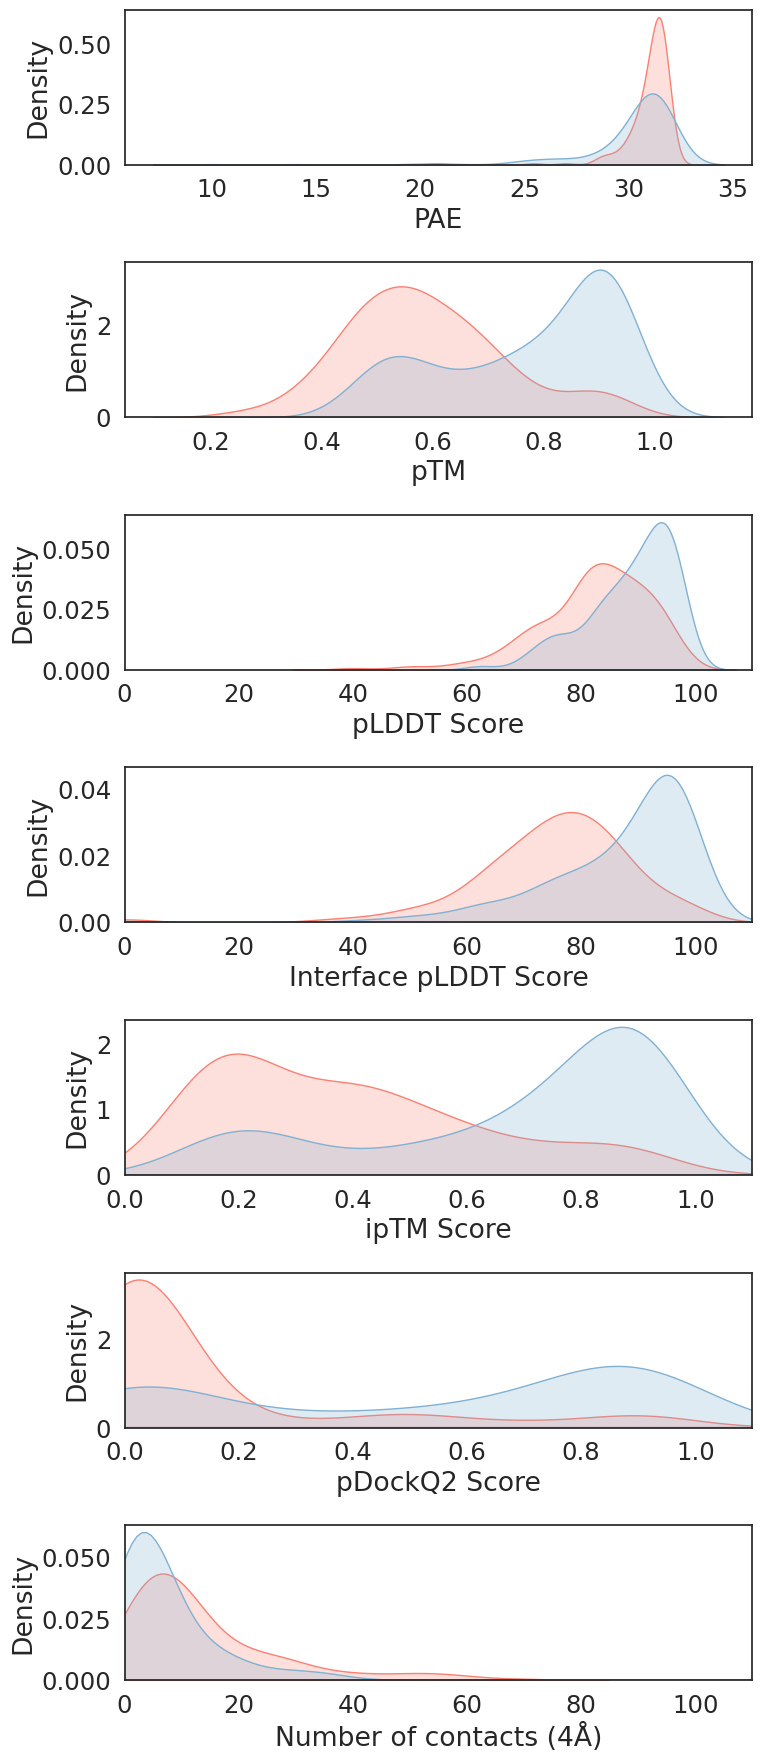

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', font_scale=1.6)
fig, axes = plt.subplots(7, 1, figsize=(8, 18))  # 8 rows, 1 column
colors = ['#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#ffed6f', '#ccebc5', '#8dd3c7', '#bebada', '#bc80bd', '#fccde5', '#d9d9d9']

# --- 1. PAE ---
sns.kdeplot(monomer_max_pae, label='Monomer', fill=True, color=colors[0], ax=axes[0])
sns.kdeplot(dimer_max_pae, label='Dimer', fill=True, color=colors[1], ax=axes[0])
axes[0].set_xlabel('PAE')
axes[0].set_ylabel('Density')
axes[0].legend().remove()

# --- 2. pTM ---
sns.kdeplot(monomer_max_ptm, label='Monomer', fill=True, color=colors[0], ax=axes[1])
sns.kdeplot(dimer_max_ptm, label='Dimer', fill=True, color=colors[1], ax=axes[1])
axes[1].set_xlabel('pTM')
axes[1].set_ylabel('Density')
axes[1].legend().remove()

# --- 3. pLDDT ---
sns.kdeplot(monomer_max_plddt, label='Monomer', fill=True, color=colors[0], ax=axes[2])
sns.kdeplot(dimer_max_plddt, label='Dimer', fill=True, color=colors[1], ax=axes[2])
axes[2].set_xlim(0, 110)
axes[2].set_xlabel('pLDDT Score')
axes[2].set_ylabel('Density')
axes[2].legend().remove()

# --- 4. Interface pLDDT ---
sns.kdeplot(monomer_max_iplddt, label='Monomer', fill=True, color=colors[0], ax=axes[3])
sns.kdeplot(dimer_max_iplddt, label='Dimer', fill=True, color=colors[1], ax=axes[3])
axes[3].set_xlim(0, 110)
axes[3].set_xlabel('Interface pLDDT Score')
axes[3].set_ylabel('Density')
axes[3].legend().remove()

# --- 5. ipTM ---
sns.kdeplot(monomer_max_iptm, label='Monomer', fill=True, color=colors[0], ax=axes[4])
sns.kdeplot(dimer_max_iptm, label='Dimer', fill=True, color=colors[1], ax=axes[4])
axes[4].set_xlim(0, 1.1)
axes[4].set_xlabel('ipTM Score')
axes[4].set_ylabel('Density')
axes[4].legend().remove()

# --- 6. pDockQ2 ---
sns.kdeplot(monomer_max_pdockq2, label='Monomer', fill=True, color=colors[0], ax=axes[5])
sns.kdeplot(dimer_max_pdockq2, label='Dimer', fill=True, color=colors[1], ax=axes[5])
axes[5].set_xlim(0, 1.1)
axes[5].set_xlabel('pDockQ2 Score')
axes[5].set_ylabel('Density')
axes[5].legend().remove()

# --- 7. Number of contacts ---
sns.kdeplot(monomer_max_ncontacts, label='Monomer', fill=True, color=colors[0], ax=axes[6])
sns.kdeplot(dimer_max_ncontacts, label='Dimer', fill=True, color=colors[1], ax=axes[6])
axes[6].set_xlim(0, 110)
axes[6].set_xlabel('Number of contacts (4Å)')
axes[6].set_ylabel('Density')
axes[6].legend().remove()


# Layout adjustments
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_max_metric_dist.png', dpi=300, bbox_inches='tight')
plt.show()


## Make plots of different cutoff values

pDockQ2:
  AUC = 0.777
  Optimal threshold (Youden's J) = 0.202
  TPR = 0.703, FPR = 0.179, J = 0.524

pLDDT:
  AUC = 0.715
  Optimal threshold (Youden's J) = 88.942
  TPR = 0.600, FPR = 0.244, J = 0.356

ipTM:
  AUC = 0.797
  Optimal threshold (Youden's J) = 0.680
  TPR = 0.682, FPR = 0.137, J = 0.545

pTM:
  AUC = 0.798
  Optimal threshold (Youden's J) = 0.740
  TPR = 0.662, FPR = 0.143, J = 0.519

Interface pLDDT:
  AUC = 0.769
  Optimal threshold (Youden's J) = 88.857
  TPR = 0.595, FPR = 0.095, J = 0.500



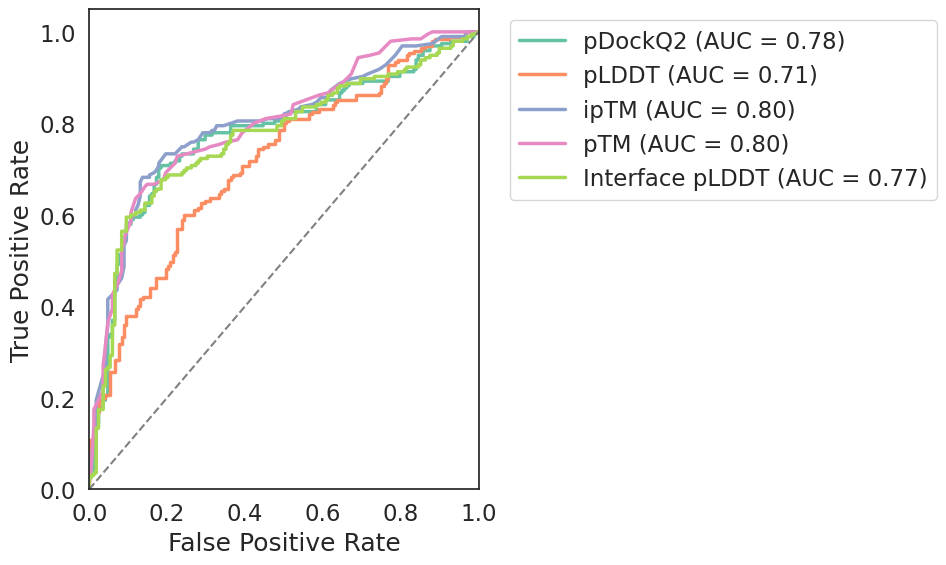

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(10, 6))

# Dictionary of data to loop through: label -> (monomer_scores, dimer_scores)
datasets = {
    'pDockQ2': (monomer_max_pdockq2, dimer_max_pdockq2),
    'pLDDT': (monomer_max_plddt, dimer_max_plddt),
    'ipTM': (monomer_max_iptm, dimer_max_iptm),
    'pTM': (monomer_max_ptm, dimer_max_ptm),
    'Interface pLDDT': (monomer_max_iplddt, dimer_max_iplddt),
}

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

for (label, (monomer_scores, dimer_scores)), color in zip(datasets.items(), colors):
    y_true = np.concatenate([np.zeros_like(monomer_scores), np.ones_like(dimer_scores)])
    y_scores = np.concatenate([monomer_scores, dimer_scores])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Compute Youden's J
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    optimal_cutoff = thresholds[best_idx]

    # Print stats
    print(f"{label}:")
    print(f"  AUC = {roc_auc:.3f}")
    print(f"  Optimal threshold (Youden's J) = {optimal_cutoff:.3f}")
    print(f"  TPR = {tpr[best_idx]:.3f}, FPR = {fpr[best_idx]:.3f}, J = {youden_j[best_idx]:.3f}")
    print()

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', lw=2.5, color=color)

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', )

# Aesthetics
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_max_metric_ROC.png',  dpi=300, bbox_inches='tight')
plt.show()


pDockQ2:
  AUC = 0.785
  Optimal threshold (Youden's J) = 0.052
  TPR = 0.718, FPR = 0.202, J = 0.516

pLDDT:
  AUC = 0.706
  Optimal threshold (Youden's J) = 84.790
  TPR = 0.641, FPR = 0.310, J = 0.332

ipTM:
  AUC = 0.807
  Optimal threshold (Youden's J) = 0.342
  TPR = 0.754, FPR = 0.214, J = 0.540

pTM:
  AUC = 0.801
  Optimal threshold (Youden's J) = 0.640
  TPR = 0.662, FPR = 0.113, J = 0.548

Interface pLDDT:
  AUC = 0.769
  Optimal threshold (Youden's J) = 80.011
  TPR = 0.600, FPR = 0.113, J = 0.487



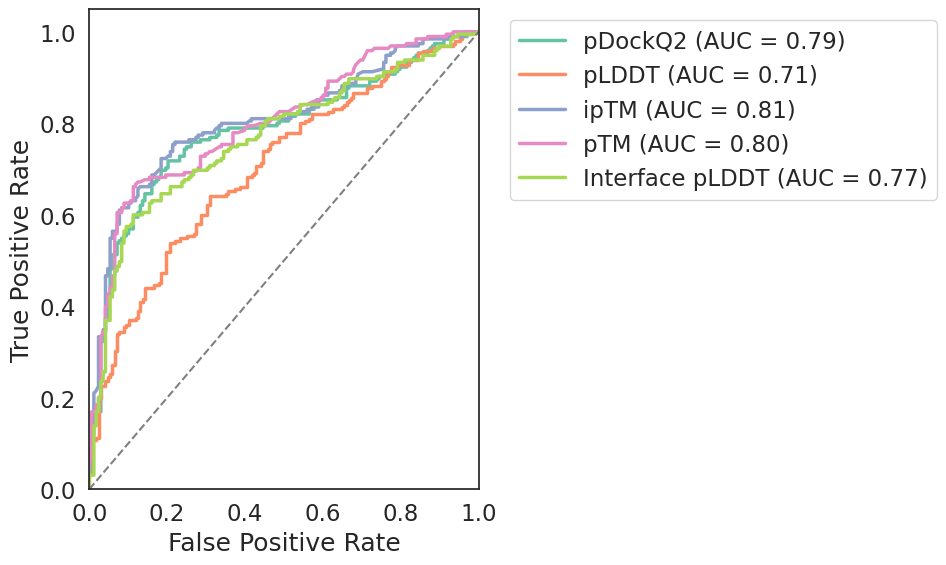

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(10, 6))

# Dictionary of data to loop through: label -> (monomer_scores, dimer_scores)
datasets = {
    'pDockQ2': (monomer_mean_pdockq2, dimer_mean_pdockq2),
    'pLDDT': (monomer_mean_plddt, dimer_mean_plddt),
    'ipTM': (monomer_mean_iptm, dimer_mean_iptm),
    'pTM': (monomer_mean_ptm, dimer_mean_ptm),
    'Interface pLDDT': (monomer_mean_iplddt, dimer_mean_iplddt),
}

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

for (label, (monomer_scores, dimer_scores)), color in zip(datasets.items(), colors):
    y_true = np.concatenate([np.zeros_like(monomer_scores), np.ones_like(dimer_scores)])
    y_scores = np.concatenate([monomer_scores, dimer_scores])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Compute Youden's J statistic
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    optimal_cutoff = thresholds[best_idx]

    # Print Youden’s J results
    print(f"{label}:")
    print(f"  AUC = {roc_auc:.3f}")
    print(f"  Optimal threshold (Youden's J) = {optimal_cutoff:.3f}")
    print(f"  TPR = {tpr[best_idx]:.3f}, FPR = {fpr[best_idx]:.3f}, J = {youden_j[best_idx]:.3f}")
    print()

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', lw=2.5, color=color)

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', )

# Aesthetics
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_mean_metric_ROC.png',  dpi=300, bbox_inches='tight')
plt.show()


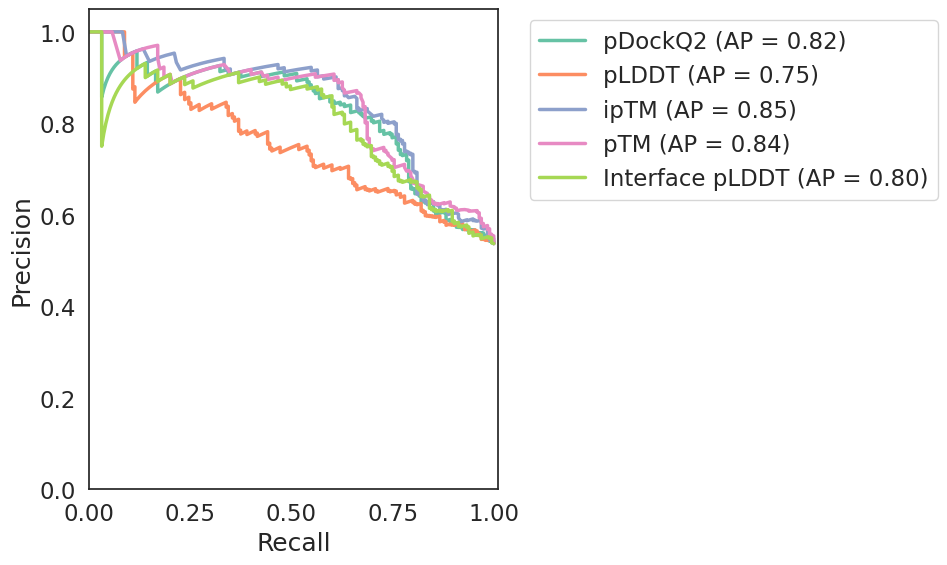

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(10, 6))

# Dictionary of data to loop through: label -> (monomer_scores, dimer_scores)
datasets = {
    'pDockQ2': (monomer_mean_pdockq2, dimer_mean_pdockq2),
    'pLDDT': (monomer_mean_plddt, dimer_mean_plddt),
    'ipTM': (monomer_mean_iptm, dimer_mean_iptm),
    'pTM': (monomer_mean_ptm, dimer_mean_ptm),
    'Interface pLDDT': (monomer_mean_iplddt, dimer_mean_iplddt),
}

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

for (label, (monomer_scores, dimer_scores)), color in zip(datasets.items(), colors):
    y_true = np.concatenate([np.zeros_like(monomer_scores), np.ones_like(dimer_scores)])
    y_scores = np.concatenate([monomer_scores, dimer_scores])
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    plt.plot(recall, precision, label=f'{label} (AP = {ap:.2f})', lw=2.5, color=color)

# Aesthetics
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1.01)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_mean_metric_PR.png',  dpi=300, bbox_inches='tight')
plt.show()


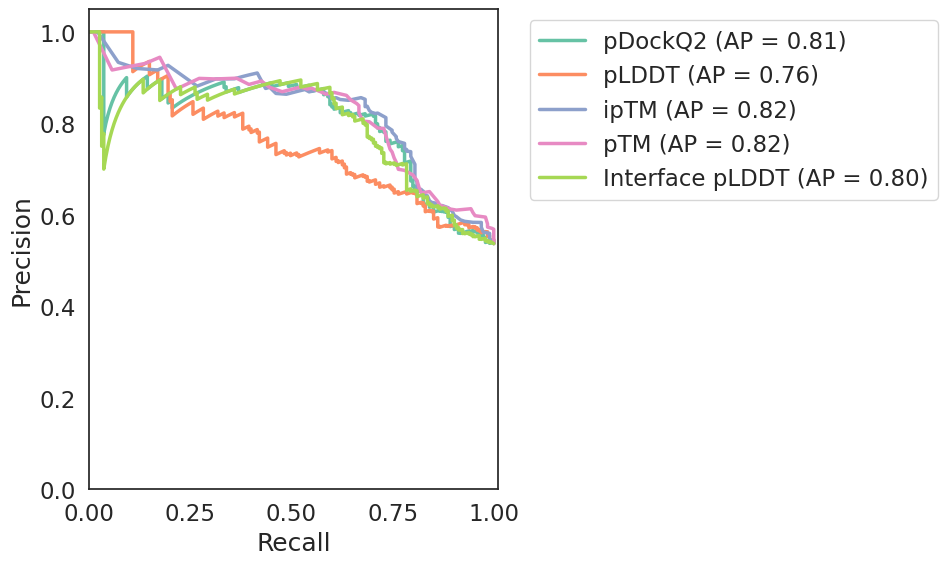

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(10, 6))

# Dictionary of data to loop through: label -> (monomer_scores, dimer_scores)
datasets = {
    'pDockQ2': (monomer_max_pdockq2, dimer_max_pdockq2),
    'pLDDT': (monomer_max_plddt, dimer_max_plddt),
    'ipTM': (monomer_max_iptm, dimer_max_iptm),
    'pTM': (monomer_max_ptm, dimer_max_ptm),
    'Interface pLDDT': (monomer_max_iplddt, dimer_max_iplddt),
}

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

for (label, (monomer_scores, dimer_scores)), color in zip(datasets.items(), colors):
    y_true = np.concatenate([np.zeros_like(monomer_scores), np.ones_like(dimer_scores)])
    y_scores = np.concatenate([monomer_scores, dimer_scores])
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    plt.plot(recall, precision, label=f'{label} (AP = {ap:.2f})', lw=2.5, color=color)

# Aesthetics
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 1.01)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig('../figures/monomer_dimer_max_metric_PR.png',  dpi=300, bbox_inches='tight')
plt.show()


In [20]:
from sklearn.metrics import precision_recall_curve

# Prepare inputs
monomer_scores = monomer_mean_iptm
dimer_scores = dimer_mean_iptm

y_true = np.concatenate([np.zeros_like(monomer_scores), np.ones_like(dimer_scores)])
y_scores = np.concatenate([monomer_scores, dimer_scores])

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# thresholds is len - 1 compared to precision/recall
# So we match it up like this:
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if p >= 0.9:
        print(f"Threshold achieving ≥90% precision: ipTM = {t:.3f}, Recall = {r:.3f}")
        break
else:
    print("No threshold achieves 90% precision.")


Threshold achieving ≥90% precision: ipTM = 0.572, Recall = 0.610


# Combined Metrics Analysis: Machine Learning Approach

This section compares the performance of using all metrics together versus ipTM alone using various machine learning approaches.

In [21]:
# Data preparation for combined metrics analysis
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Prepare dataset with all metrics (using mean aggregation)
# First, ensure all arrays have the same length
min_length = min(
    len(monomer_mean_iptm), len(monomer_mean_ptm), len(monomer_mean_pdockq2),
    len(monomer_mean_plddt), len(monomer_mean_iplddt),
    len(dimer_mean_iptm), len(dimer_mean_ptm), len(dimer_mean_pdockq2),
    len(dimer_mean_plddt), len(dimer_mean_iplddt)
)

print(f"Using {min_length} monomers and {min_length} dimers for analysis")

# Create combined dataset for mean aggregation
X_mean_combined = np.column_stack([
    # Monomer data
    monomer_mean_iptm[:min_length],
    monomer_mean_ptm[:min_length], 
    monomer_mean_pdockq2[:min_length],
    monomer_mean_plddt[:min_length],
    monomer_mean_iplddt[:min_length]
])

X_mean_combined = np.vstack([
    X_mean_combined,
    # Dimer data  
    np.column_stack([
        dimer_mean_iptm[:min_length],
        dimer_mean_ptm[:min_length],
        dimer_mean_pdockq2[:min_length], 
        dimer_mean_plddt[:min_length],
        dimer_mean_iplddt[:min_length]
    ])
])

# Create labels (0 = monomer, 1 = dimer)
y_combined = np.concatenate([
    np.zeros(min_length),  # monomers
    np.ones(min_length)    # dimers
])

# Create dataset with just ipTM for comparison
X_iptm_only = X_mean_combined[:, 0].reshape(-1, 1)  # ipTM is first column

# Feature names for interpretability
feature_names = ['ipTM', 'pTM', 'pDockQ2', 'pLDDT', 'Interface_pLDDT']

print(f"Combined dataset shape: {X_mean_combined.shape}")
print(f"ipTM-only dataset shape: {X_iptm_only.shape}")
print(f"Labels shape: {y_combined.shape}")
print(f"Class distribution: {np.bincount(y_combined.astype(int))}")

Using 168 monomers and 168 dimers for analysis
Combined dataset shape: (336, 5)
ipTM-only dataset shape: (336, 1)
Labels shape: (336,)
Class distribution: [168 168]


In [46]:
# Compare different machine learning models
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Store results
results_combined = {}
results_iptm_only = {}

print("=== COMBINED METRICS PERFORMANCE ===")
print()
for name, model in models.items():
    # Fit and evaluate on combined metrics
    if name == 'SVM':
        # Scale features for SVM
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_mean_combined)
        cv_scores = cross_val_score(model, X_scaled, y_combined, cv=cv, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_mean_combined, y_combined, cv=cv, scoring='roc_auc')
    
    results_combined[name] = cv_scores
    print(f"{name}:")
    print(f"  AUC-ROC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Get precision-recall AUC too
    if name == 'SVM':
        cv_pr_scores = cross_val_score(model, X_scaled, y_combined, cv=cv, scoring='average_precision')
    else:
        cv_pr_scores = cross_val_score(model, X_mean_combined, y_combined, cv=cv, scoring='average_precision')
    print(f"  AUC-PR:  {cv_pr_scores.mean():.3f} ± {cv_pr_scores.std():.3f}")
    print()

print("\n=== ipTM ONLY PERFORMANCE ===")
print()
for name, model in models.items():
    # Fit and evaluate on ipTM only
    if name == 'SVM':
        scaler = StandardScaler()
        X_iptm_scaled = scaler.fit_transform(X_iptm_only)
        cv_scores = cross_val_score(model, X_iptm_scaled, y_combined, cv=cv, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_iptm_only, y_combined, cv=cv, scoring='roc_auc')
    
    results_iptm_only[name] = cv_scores
    print(f"{name}:")
    print(f"  AUC-ROC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Get precision-recall AUC too
    if name == 'SVM':
        cv_pr_scores = cross_val_score(model, X_iptm_scaled, y_combined, cv=cv, scoring='average_precision')
    else:
        cv_pr_scores = cross_val_score(model, X_iptm_only, y_combined, cv=cv, scoring='average_precision')
    print(f"  AUC-PR:  {cv_pr_scores.mean():.3f} ± {cv_pr_scores.std():.3f}")
    print()

=== COMBINED METRICS PERFORMANCE ===

Logistic Regression:
  AUC-ROC: 0.781 ± 0.045
  AUC-PR:  0.812 ± 0.045

Random Forest:
  AUC-ROC: 0.780 ± 0.022
  AUC-PR:  0.811 ± 0.012

Gradient Boosting:
  AUC-ROC: 0.768 ± 0.029
  AUC-PR:  0.808 ± 0.032

SVM:
  AUC-ROC: 0.783 ± 0.033
  AUC-PR:  0.823 ± 0.033


=== ipTM ONLY PERFORMANCE ===

Logistic Regression:
  AUC-ROC: 0.797 ± 0.046
  AUC-PR:  0.826 ± 0.044

Random Forest:
  AUC-ROC: 0.773 ± 0.030
  AUC-PR:  0.798 ± 0.036

Gradient Boosting:
  AUC-ROC: 0.788 ± 0.046
  AUC-PR:  0.805 ± 0.041

SVM:
  AUC-ROC: 0.804 ± 0.035
  AUC-PR:  0.806 ± 0.019



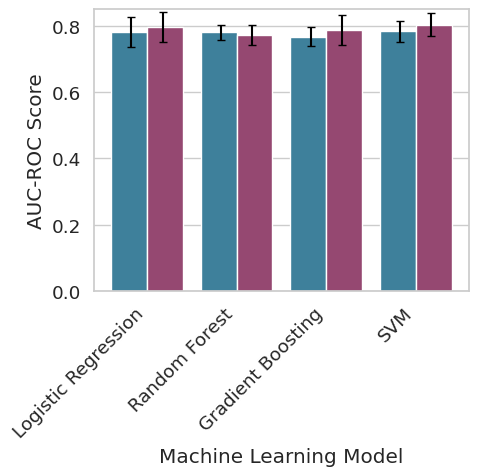

In [65]:
# Create barplot comparing combined metrics vs ipTM-only performance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare data for plotting
model_names = list(models.keys())
combined_means = [results_combined[name].mean() for name in model_names]
iptm_means = [results_iptm_only[name].mean() for name in model_names]
combined_stds = [results_combined[name].std() for name in model_names]
iptm_stds = [results_iptm_only[name].std() for name in model_names]

# Create DataFrame for plotting
plot_data = []
for i, model in enumerate(model_names):
    plot_data.append({
        'Model': model,
        'Method': 'Combined Metrics',
        'AUC-ROC': combined_means[i],
        'Std': combined_stds[i]
    })
    plot_data.append({
        'Model': model,
        'Method': 'ipTM Only',
        'AUC-ROC': iptm_means[i],
        'Std': iptm_stds[i]
    })

plot_df = pd.DataFrame(plot_data)

# Create the barplot
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(5, 5))

# Create barplot with error bars
ax = sns.barplot(data=plot_df, x='Model', y='AUC-ROC', hue='Method', 
                 palette=['#2E86AB', '#A23B72'], capsize=0.1)

# Add error bars manually
x_positions = np.arange(len(model_names))
width = 0.35

for i, (model, combined_mean, iptm_mean, combined_std, iptm_std) in enumerate(
    zip(model_names, combined_means, iptm_means, combined_stds, iptm_stds)):
    
    # Error bars for combined metrics
    plt.errorbar(x_positions[i] - width/2, combined_mean, yerr=combined_std, 
                fmt='none', color='black', capsize=3, capthick=1)
    
    # Error bars for ipTM only
    plt.errorbar(x_positions[i] + width/2, iptm_mean, yerr=iptm_std, 
                fmt='none', color='black', capsize=3, capthick=1)

# Customize the plot
plt.ylabel('AUC-ROC Score')
plt.xlabel('Machine Learning Model')
plt.ylim(0, 0.85)  # Focus on the relevant range
plt.xticks(rotation=45, ha='right')


# Move legend outside the plot area
#plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='lower left')
plt.legend().set_visible(False)
plt.tight_layout()
plt.savefig('../figures/ml_model_comparison_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Compare number of structures for each level

In [ ]:
num_structures = [1,2,3,4,5]
dimer_mean_sample_iptm = dict() 
monomer_mean_sample_iptm = dict()
dimer_max_sample_iptm = dict() 
monomer_max_sample_iptm = dict()

for s in num_structures: 

    dimer_mean_sample_iptm[str(s) + '_structures'] = dict()
    monomer_mean_sample_iptm[str(s) + '_structures'] = dict()
    dimer_max_sample_iptm[str(s) + '_structures'] = dict() 
    monomer_max_sample_iptm[str(s) + '_structures'] = dict()

    for m in seen_monomers: 
        sample = np.array(random.sample(range(5), s))
        metrics = pickle.load(open(pickle_paths.get(m), 'rb')).get('2_subunits')
        sample_keys = np.array(list(metrics.keys()))[sample]
        sample_iptm = [metrics.get(k).get('iptm') for k in sample_keys]

        monomer_mean_sample_iptm[str(s) + '_structures'][m] = np.mean(sample_iptm)
        monomer_max_sample_iptm[str(s) + '_structures'][m] = np.max(sample_iptm)


    for d in seen_dimers: 
        sample = np.array(random.sample(range(5), s) )
        metrics = pickle.load(open(pickle_paths.get(d), 'rb')).get('2_subunits')
        sample_keys = np.array(list(metrics.keys()))[sample] 
        sample_iptm = [metrics.get(k).get('iptm') for k in sample_keys]

        dimer_mean_sample_iptm[str(s) + '_structures'][d] = np.mean(sample_iptm)
        dimer_max_sample_iptm[str(s) + '_structures'][d] = np.max(sample_iptm)

In [78]:
# Compute AUC scores for sampled ipTM data
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize dictionaries to store AUC results
auc_results = {
    'mean_auc': {},
    'max_auc': {}
}

num_structures = [1, 2, 3, 4, 5]

print("Computing AUC scores for sampled ipTM data...")
print("=" * 50)

for s in num_structures:
    structure_key = str(s) + '_structures'
    
    # Get mean aggregation scores
    monomer_mean_scores = list(monomer_mean_sample_iptm[structure_key].values())
    dimer_mean_scores = list(dimer_mean_sample_iptm[structure_key].values())
    
    # Get max aggregation scores  
    monomer_max_scores = list(monomer_max_sample_iptm[structure_key].values())
    dimer_max_scores = list(dimer_max_sample_iptm[structure_key].values())
    
    # Create true labels (0 for monomers, 1 for dimers)
    y_true = np.concatenate([
        np.zeros(len(monomer_mean_scores)),  # monomers = 0
        np.ones(len(dimer_mean_scores))      # dimers = 1
    ])
    
    # Combine scores for AUC calculation
    y_scores_mean = np.concatenate([monomer_mean_scores, dimer_mean_scores])
    y_scores_max = np.concatenate([monomer_max_scores, dimer_max_scores])
    
    # Calculate AUC scores
    auc_mean = roc_auc_score(y_true, y_scores_mean)
    auc_max = roc_auc_score(y_true, y_scores_max)
    
    # Store results
    auc_results['mean_auc'][s] = auc_mean
    auc_results['max_auc'][s] = auc_max
    
    print(f"{s} structures:")
    print(f"  Mean aggregation AUC: {auc_mean:.4f}")
    print(f"  Max aggregation AUC:  {auc_max:.4f}")
    print(f"  Difference (Max - Mean): {auc_max - auc_mean:+.4f}")
    print()

print("✓ AUC computation complete!")
print()

# Create boxplot comparing mean and max aggregation methods
sns.set_style("whitegrid")

# Prepare data for plotting
plot_data = []
for s in num_structures:
    plot_data.append({
        'n_structures': s,
        'method': 'Mean Aggregation',
        'auc': auc_results['mean_auc'][s]
    })
    plot_data.append({
        'n_structures': s,
        'method': 'Max Aggregation', 
        'auc': auc_results['max_auc'][s]
    })

plot_df = pd.DataFrame(plot_data)

Computing AUC scores for sampled ipTM data...
1 structures:
  Mean aggregation AUC: 0.7746
  Max aggregation AUC:  0.7746
  Difference (Max - Mean): +0.0000

2 structures:
  Mean aggregation AUC: 0.7922
  Max aggregation AUC:  0.7879
  Difference (Max - Mean): -0.0044

3 structures:
  Mean aggregation AUC: 0.8007
  Max aggregation AUC:  0.7970
  Difference (Max - Mean): -0.0037

4 structures:
  Mean aggregation AUC: 0.8077
  Max aggregation AUC:  0.7955
  Difference (Max - Mean): -0.0122

5 structures:
  Mean aggregation AUC: 0.8071
  Max aggregation AUC:  0.7972
  Difference (Max - Mean): -0.0099

✓ AUC computation complete!



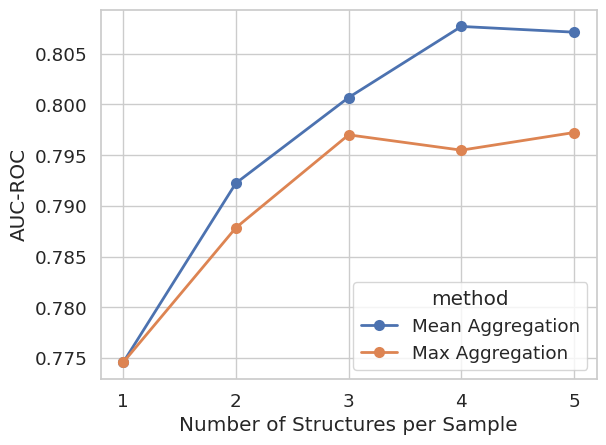

In [88]:
# Create line plot with markers
sns.lineplot(data=plot_df, x='n_structures', y='auc', hue='method', markers=True, marker='o', markersize=8, linewidth=2, markeredgewidth=0)

# Set x-tick labels to display only integers
plt.xticks(ticks=range(int(plot_df['n_structures'].min()), int(plot_df['n_structures'].max()) + 1))

# set the axes labels 
plt.ylabel('AUC-ROC')
plt.xlabel('Number of Structures per Sample')   

# Show the plot
plt.show()

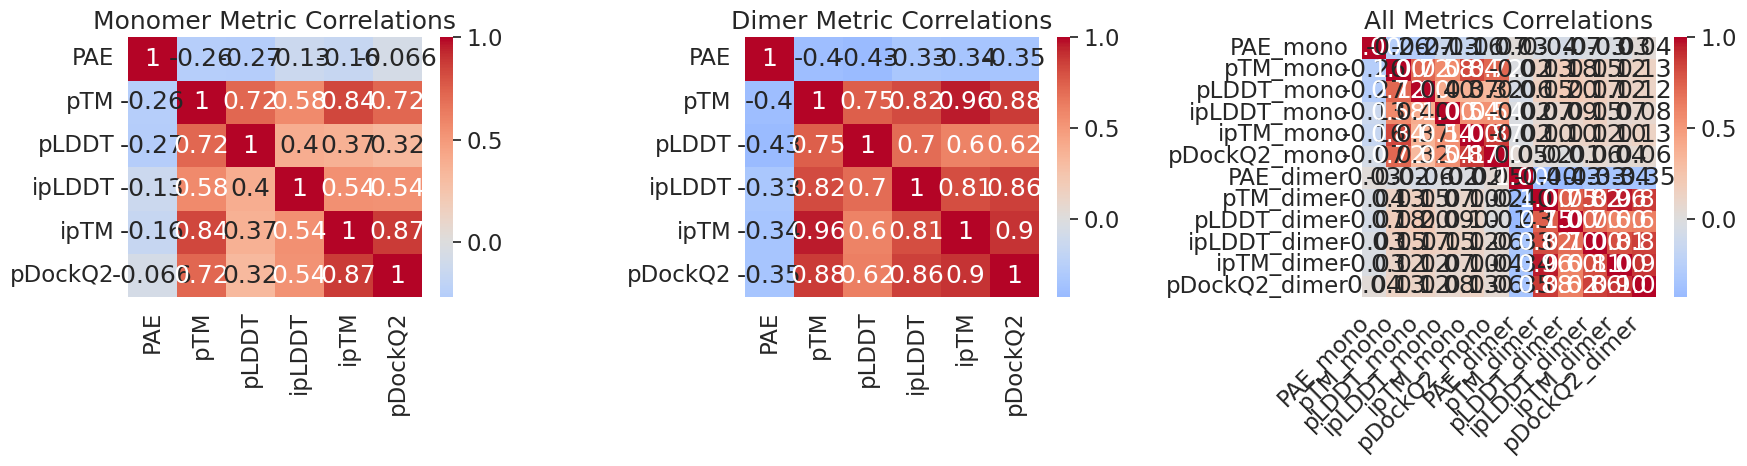

In [26]:
## Correlation heatmap between metrics
# Prepare correlation data
correlation_data = pd.DataFrame({
    'PAE_mono': monomer_mean_pae[:min(len(monomer_mean_pae), len(monomer_mean_ptm))],
    'pTM_mono': monomer_mean_ptm[:min(len(monomer_mean_pae), len(monomer_mean_ptm))],
    'pLDDT_mono': monomer_mean_plddt[:min(len(monomer_mean_pae), len(monomer_mean_ptm))],
    'ipLDDT_mono': monomer_mean_iplddt[:min(len(monomer_mean_pae), len(monomer_mean_ptm))],
    'ipTM_mono': monomer_mean_iptm[:min(len(monomer_mean_pae), len(monomer_mean_ptm))],
    'pDockQ2_mono': monomer_mean_pdockq2[:min(len(monomer_mean_pae), len(monomer_mean_ptm))]
})

dimer_correlation_data = pd.DataFrame({
    'PAE_dimer': dimer_mean_pae[:min(len(dimer_mean_pae), len(dimer_mean_ptm))],
    'pTM_dimer': dimer_mean_ptm[:min(len(dimer_mean_pae), len(dimer_mean_ptm))],
    'pLDDT_dimer': dimer_mean_plddt[:min(len(dimer_mean_pae), len(dimer_mean_ptm))],
    'ipLDDT_dimer': dimer_mean_iplddt[:min(len(dimer_mean_pae), len(dimer_mean_ptm))],
    'ipTM_dimer': dimer_mean_iptm[:min(len(dimer_mean_pae), len(dimer_mean_ptm))],
    'pDockQ2_dimer': dimer_mean_pdockq2[:min(len(dimer_mean_pae), len(dimer_mean_ptm))]
})

# Combine for overall correlation
all_correlation_data = pd.concat([correlation_data, dimer_correlation_data], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Monomer correlations
corr_mono = correlation_data.corr()
sns.heatmap(corr_mono, annot=True, cmap='coolwarm', center=0, ax=ax1, 
            xticklabels=[x.replace('_mono', '') for x in corr_mono.columns],
            yticklabels=[x.replace('_mono', '') for x in corr_mono.columns])
ax1.set_title('Monomer Metric Correlations')

# Dimer correlations
corr_dimer = dimer_correlation_data.corr()
sns.heatmap(corr_dimer, annot=True, cmap='coolwarm', center=0, ax=ax2,
            xticklabels=[x.replace('_dimer', '') for x in corr_dimer.columns],
            yticklabels=[x.replace('_dimer', '') for x in corr_dimer.columns])
ax2.set_title('Dimer Metric Correlations')

# Overall correlations
corr_all = all_correlation_data.corr()
sns.heatmap(corr_all, annot=True, cmap='coolwarm', center=0, ax=ax3, fmt='.2f')
ax3.set_title('All Metrics Correlations')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../figures/metrics_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Comprehensive Analysis: Maximum vs Mean Metric Aggregation

This analysis compares the performance and characteristics of using maximum vs mean aggregation across the 5 AlphaFold replicates for each metric.

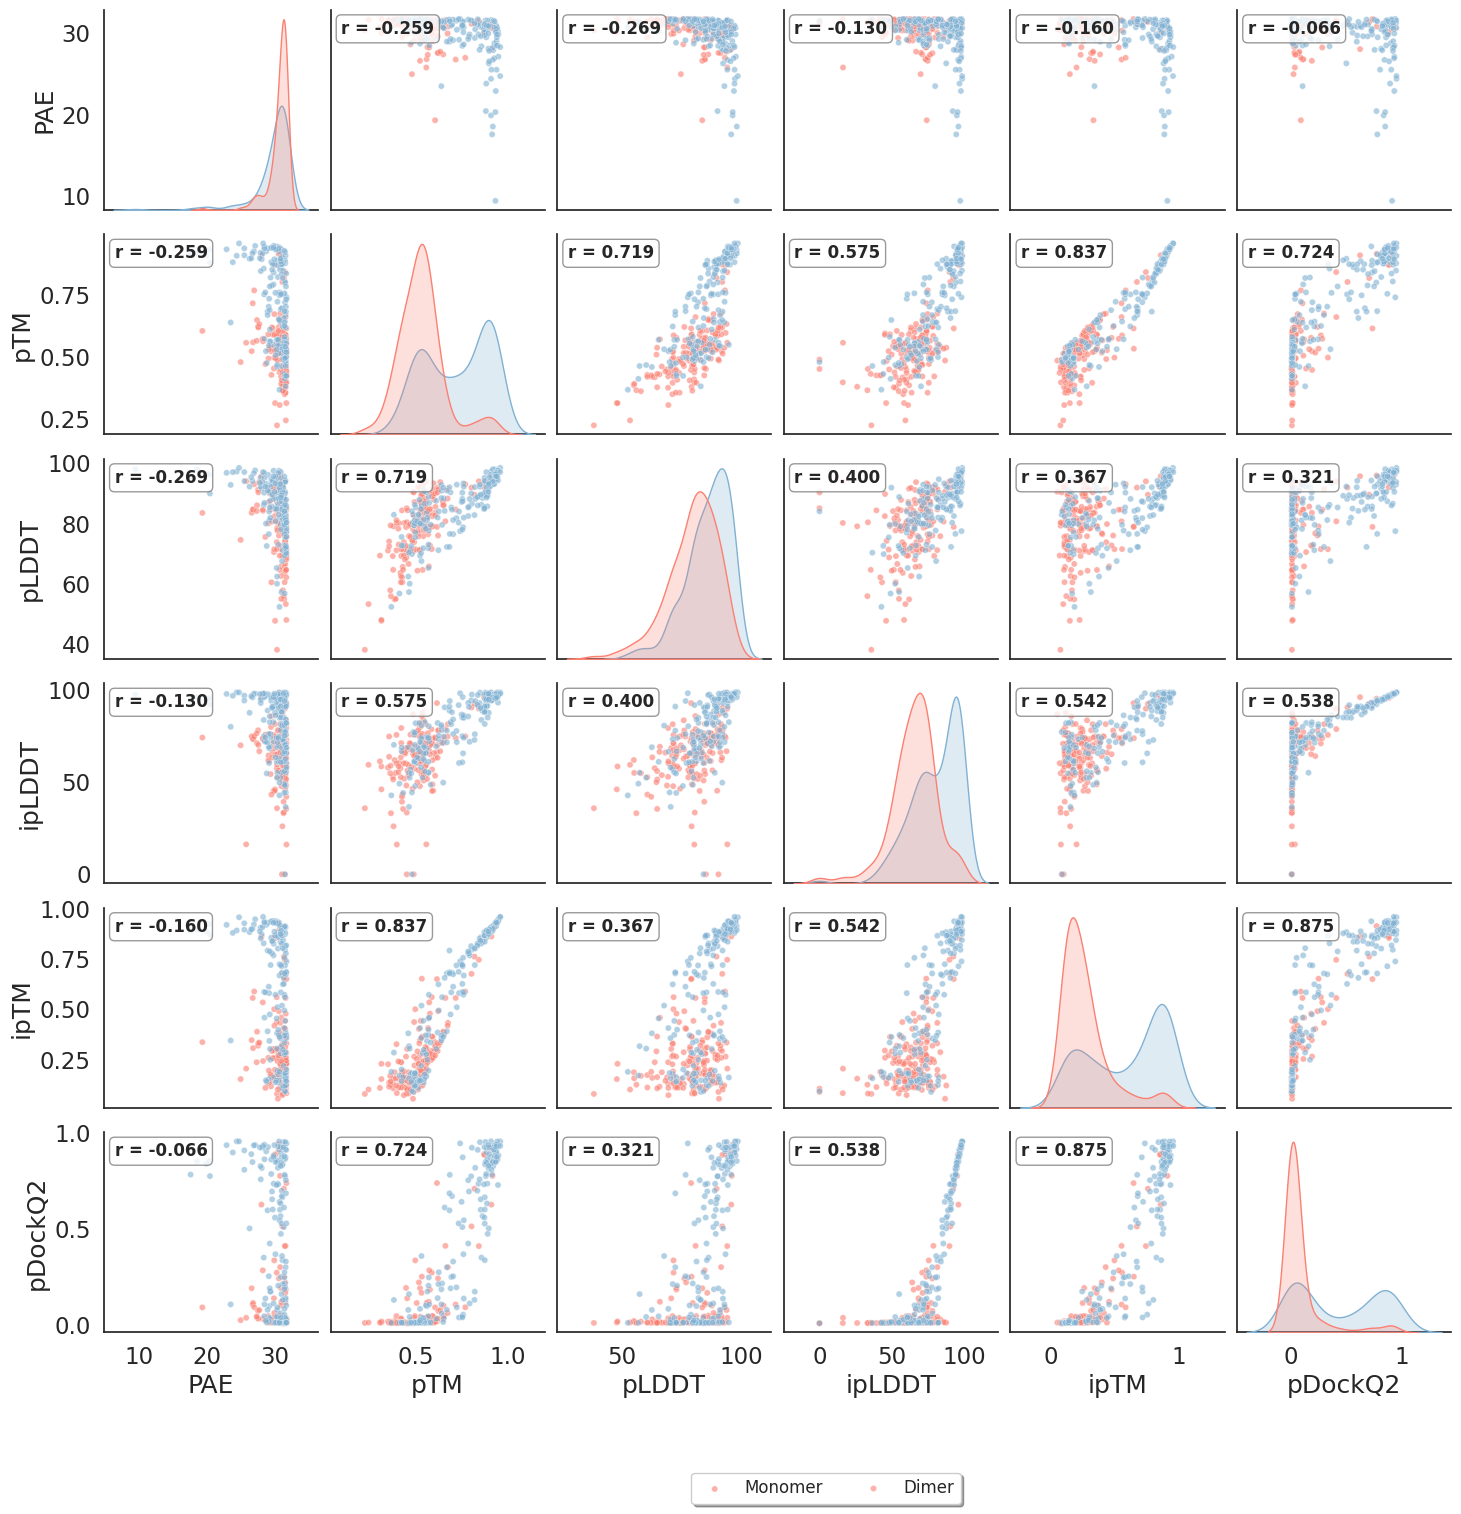

Enhanced pairplot created with correlation coefficients!
Each scatter plot now shows the Pearson correlation coefficient (r) in the top-left corner.
Legend has been moved to the bottom of the figure.


In [43]:
# Enhanced version of the original pairplot with correlation coefficients
import numpy as np
from scipy import stats

# Prepare data for pairplot (same as original)
min_length = min(len(monomer_mean_pae), len(monomer_mean_ptm), len(monomer_mean_plddt),
                 len(monomer_mean_iplddt), len(monomer_mean_iptm), len(monomer_mean_pdockq2))

pairplot_data_enhanced = pd.DataFrame({
    'PAE': list(monomer_mean_pae[:min_length]) + list(dimer_mean_pae[:min_length]),
    'pTM': list(monomer_mean_ptm[:min_length]) + list(dimer_mean_ptm[:min_length]),
    'pLDDT': list(monomer_mean_plddt[:min_length]) + list(dimer_mean_plddt[:min_length]),
    'ipLDDT': list(monomer_mean_iplddt[:min_length]) + list(dimer_mean_iplddt[:min_length]),
    'ipTM': list(monomer_mean_iptm[:min_length]) + list(dimer_mean_iptm[:min_length]),
    'pDockQ2': list(monomer_mean_pdockq2[:min_length]) + list(dimer_mean_pdockq2[:min_length]),
    'Type': ['Monomer'] * min_length + ['Dimer'] * min_length
})

# Create pairplot (same as original)
g = sns.pairplot(pairplot_data_enhanced, hue='Type', palette=['#fb8072', '#80b1d3'], 
                 plot_kws={'alpha': 0.6, 's': 20}, diag_kind='kde')

# Track which subplots have already had correlation text added
correlation_added = set()

# Function to add correlation coefficients to scatter plots
def add_correlation_text(x, y, **kwargs):
    ax = plt.gca()
    
    # Create a unique identifier for this subplot based on axis position
    subplot_id = (ax.get_position().x0, ax.get_position().y0)
    
    # Only add correlation text if it hasn't been added to this subplot yet
    if subplot_id not in correlation_added:
        # Calculate correlation coefficient using all data (both monomer and dimer)
        r, p = stats.pearsonr(x, y)
        
        # Add correlation text to the plot with better positioning and styling
        ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        # Mark this subplot as having correlation text added
        correlation_added.add(subplot_id)

# Apply correlation function to off-diagonal plots only
g.map_offdiag(add_correlation_text)

# Move legend to bottom of the figure
g._legend.remove()  # Remove the default legend
g.fig.legend(labels=['Monomer', 'Dimer'], 
             loc='lower center', 
             bbox_to_anchor=(0.5, -0.02),
             ncol=2, 
             frameon=True, 
             fancybox=True,
             shadow=True,
             fontsize=12)

# Adjust layout to make room for the bottom legend
plt.subplots_adjust(bottom=0.1)

# Save and show (same as original but with new filename)
plt.savefig('../figures/enhanced_metrics_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced pairplot created with correlation coefficients!")
print("Each scatter plot now shows the Pearson correlation coefficient (r) in the top-left corner.")
print("Legend has been moved to the bottom of the figure.")

## See what the ipTM scores are of proteins in the unseen set

In [43]:
# nake a dataframe for the un

validation_phrogs = [p for p in phrogs_pass_alphafold_unseen if phrogs_pass_alphafold_seen_state.get(p) in (['Monomer', 'Homo 2-mer'])]
validation_states = [phrogs_pass_alphafold_seen_state.get(p) for p in validate_phrogs] 

# for the validation states get their iptm when folded as a dimer
validation_iptm = [] 
for v in validation_phrogs:
    metrics = pickle.load(open(pickle_paths.get(v), 'rb'))
    iptm =  [metrics.get('2_subunits').get('rep_' + str(i)).get('iptm') for i in range(1,6)] 
    mean_iptm = np.mean(iptm)
    validation_iptm.append(mean_iptm)

# assemble into a dataframe 
validation_iptm_df = pd.DataFrame({'phrog': validation_phrogs, 'state': validation_states, 'iptm': validation_iptm})

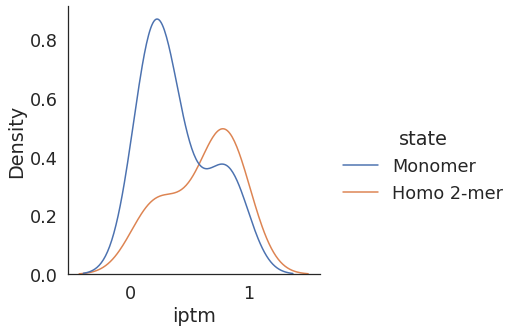

In [53]:
sns.displot(data = validation_iptm_df, hue= 'state', x= 'iptm', kind='kde')

In [56]:
validation_iptm_df.sort_values('iptm', ascending = False)

,phrog,state,iptm
7,phrog_255,Homo 2-mer,0.918
9,phrog_1384,Homo 2-mer,0.876
12,phrog_8702,Monomer,0.862
8,phrog_38247,Monomer,0.860
16,phrog_292,Homo 2-mer,0.768
13,phrog_755,Monomer,0.762
6,phrog_30232,Homo 2-mer,0.762
11,phrog_1856,Homo 2-mer,0.722
5,phrog_21966,Monomer,0.534
14,phrog_12654,Homo 2-mer,0.444


In [59]:
len(validation_iptm_df)

20

In [58]:
Counter(validation_iptm_df['state'])

Counter({'Monomer': 12, 'Homo 2-mer': 8})